In [65]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [66]:
df = pd.read_csv("../data/processed/train_set.csv")
df

,Tanggal,RH_avg
0,2010-01-01,85
1,2010-02-01,83
2,2010-03-01,86
3,2010-04-01,84
4,2010-05-01,80
...,...,...
4083,2021-04-23,84
4084,2021-04-24,89
4085,2021-04-25,84
4086,2021-04-26,80


In [67]:
df.isnull().sum()

Tanggal    0
RH_avg     0
dtype: int64

In [68]:
min_max_scaler = MinMaxScaler()
df["RH_avg"] = min_max_scaler.fit_transform(df[["RH_avg"]])
df

,Tanggal,RH_avg
0,2010-01-01,0.68750
1,2010-02-01,0.62500
2,2010-03-01,0.71875
3,2010-04-01,0.65625
4,2010-05-01,0.53125
...,...,...
4083,2021-04-23,0.65625
4084,2021-04-24,0.81250
4085,2021-04-25,0.65625
4086,2021-04-26,0.53125


In [69]:
dates = df["Tanggal"].values
humidity = df["RH_avg"].values

Text(0.5, 1.0, 'Humidity')

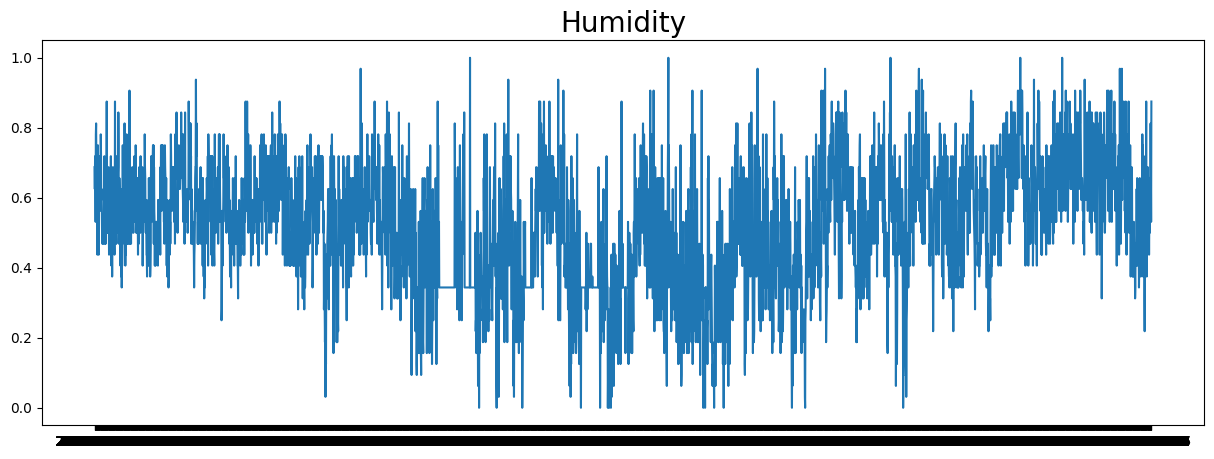

In [70]:
plt.figure(figsize=(15, 5))
plt.plot(dates, humidity)
plt.title("Humidity",
          fontsize=20)

In [71]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [72]:
train_set = windowed_dataset(humidity, window_size=60, batch_size=100, shuffle_buffer=1000)

lstm_model = tf.keras.models.Sequential([
    LSTM(60, return_sequences=True),
    LSTM(60, return_sequences=True),
    LSTM(60),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

In [73]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
lstm_model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                   optimizer=optimizer,
                   metrics=[MeanSquaredError(), RootMeanSquaredError()])

In [74]:
history_lstm = lstm_model.fit(train_set, epochs=10)

Epoch 1/10
41/41 [==============================] - 12s 155ms/step - loss: 0.2738 - mean_squared_error: 0.1131 - root_mean_squared_error: 0.3363
Epoch 2/10
41/41 [==============================] - 9s 228ms/step - loss: 0.1498 - mean_squared_error: 0.0343 - root_mean_squared_error: 0.1853
Epoch 3/10
41/41 [==============================] - 8s 196ms/step - loss: 0.1445 - mean_squared_error: 0.0321 - root_mean_squared_error: 0.1793
Epoch 4/10
41/41 [==============================] - 8s 187ms/step - loss: 0.1411 - mean_squared_error: 0.0304 - root_mean_squared_error: 0.1745
Epoch 5/10
41/41 [==============================] - 7s 163ms/step - loss: 0.1409 - mean_squared_error: 0.0305 - root_mean_squared_error: 0.1747
Epoch 6/10
41/41 [==============================] - 8s 184ms/step - loss: 0.1402 - mean_squared_error: 0.0302 - root_mean_squared_error: 0.1738
Epoch 7/10
41/41 [==============================] - 8s 183ms/step - loss: 0.1396 - mean_squared_error: 0.0301 - root_mean_squared_error

In [75]:
forecast = history_lstm.model.evaluate(train_set)
forecast

41/41 [==============================] - 5s 78ms/step - loss: 0.1331 - mean_squared_error: 0.0276 - root_mean_squared_error: 0.1662


[0.13306598365306854, 0.027638522908091545, 0.1662483811378479]

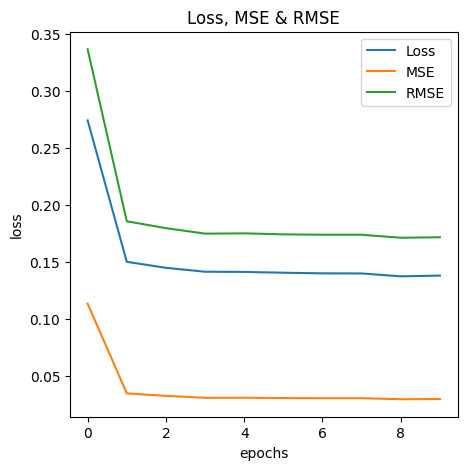

In [76]:
plt.figure(figsize=(5, 5))
plt.plot(history_lstm.history["loss"])
plt.plot(history_lstm.history["mean_squared_error"])
plt.plot(history_lstm.history["root_mean_squared_error"])
plt.title("Loss, MSE & RMSE")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Loss", "MSE", "RMSE"], loc="best")
plt.show()

In [77]:
lstm_model.save('../models/lstm_model')

INFO:tensorflow:Assets written to: ../models/lstm_model\assets


INFO:tensorflow:Assets written to: ../models/lstm_model\assets


In [78]:
model = tf.keras.models.load_model("../models/lstm_model")

In [79]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, None, 60)          14880     
                                                                 
 lstm_40 (LSTM)              (None, None, 60)          29040     
                                                                 
 lstm_41 (LSTM)              (None, 60)                29040     
                                                                 
 dense_39 (Dense)            (None, 128)               7808      
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 89089 (348.00 KB)
Trainable params: 890